# Lab One: CNN DeepDream

https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html (Links to an external site.)



## Argument For DeepDream

DeepDream can be used to determine if the CNN is learning the features we want and ignoring the features that we do not want. To test our CNN, we can feed an image or random noise and observe the output of the network. The output of each layer of the random noise can reveal what the features extracted, such as if a layer is detecting the shape of a face or a book. If our model was trained to detect dogs within an image, the model should hopefully be able to produce different species of dog or different features of a dog. If we instead see that instead the network veers off and changes the shape of the dog to look more like a cat, this may indicate that our model hasn't been trained effectively on features of a dog. 

## Inception V3 Selection

Inception framework was the original framework where DeepDream was implemented. Inception also is known for producing nice DeepDream output.

## DeepDream

### Process:
- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.

To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.

In [11]:
import numpy as np
import scipy
from PIL import Image
import imageio
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications import inception_v3
from keras import backend as K

def resize_img(img,size): 
    img = np.copy(img)
    factors = (1,
              float(size[0]) / img.shape[1],
              float(size[1]) / img.shape[2],
              1)
    return scipy.ndimage.zoom(img, factors, order = 1)


def preprocess_image(img_path):
    img = load_img(img_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def add_jitter(img, jitter=64, clip=True):
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    img = np.roll(np.roll(img, ox, -1), oy, -2) # apply jitter shift
    return img

In [12]:
# disable model training
K.set_learning_phase(0)

# Load the pre-trained VGG16 model
model = inception_v3.InceptionV3(weights='imagenet',include_top=False)

dream = model.input # variable to hold the input dreaming image
print('Model loaded.')

Model loaded.


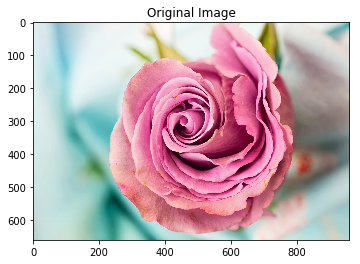

image dimensions: (660, 960, 3)


In [3]:
import cv2

img_path = 'C:/Users/mhan/Downloads/flowers.jpg'

img = Image.open(img_path)
plt.imshow(np.asarray(img))
plt.title('Original Image')
plt.show()
print('image dimensions:',np.asarray(img).shape)

In [27]:
def produce_deep_dream(img, layer_contributions, params, name_prefix='', show_intermediates=False):
    step = params['step']
    num_octave = params['num_octave']
    octave_scale = params['octave_scale']
    iterations = params['iterations']
    max_loss = params['max_loss']
    norm = params['norm']
    
    # getting all layer names from model
    layer_dict = dict([(layer.name, layer) for layer in model.layers])

    # defining the loss to be maximized for all layers
    loss = K.variable(0.)
    for layer_name in layer_contributions:
        coeff = layer_contributions[layer_name]
        activation = layer_dict[layer_name].output

        scaling = K.prod(K.cast(K.shape(activation), 'float32')) # l2 norm
        loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

    # code from larson
    
    ### added the option to chose l2 or l1 norm for gradients
    if norm == 'l2':
        grads = K.gradients(loss, dream)[0]
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) ## l2 norm
        iterate = K.function([dream], [loss, grads])

    elif norm == 'l1':
        grads = K.gradients(loss, dream)[0]
        grads /= K.mean(K.abs(grads)) ## l1 norm
        iterate = K.function([dream], [loss,grads])
        
    def eval_loss_and_grads(x):
        outs = iterate([x])
        loss_value = outs[0]
        grad_value = outs[1]
        return loss_value, grad_value

    def gradient_ascent(x, iterations, step, max_loss=None):
        for i in range(iterations):
            loss_value, grad_values = eval_loss_and_grads(x)
            if max_loss is not None and loss_value > max_loss:
                break
            print('..Loss value at', i, ':', loss_value)
            x += step * grad_values
        return x
    
    original_shape = img.shape[1:3]
    successive_shapes = [original_shape]

    # prepares a list of shape tuples defining the different scales at which to run graident ascent
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** i))
                      for dim in original_shape])
        successive_shapes.append(shape)

    successive_shapes = successive_shapes[::-1] # reverse the list of shapes so they show in increasing order

    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0]) # resize numpy array of the image to smallest scale
    
    # counter for intermediates
    octave=1

    for shape in successive_shapes:
        print('Processing image shape', shape)
        img = resize_img(img, shape) # scales up dream image
        img = gradient_ascent(img, # gradient ascent function
                              iterations=iterations,
                              step=step,
                              max_loss=max_loss)
        upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img

        img += lost_detail
        shrunk_original_img = resize_img(original_img, shape) # resize numpy array of the image to smallest scale
    
        if show_intermediates==True and octave < num_octave: # output of image at each octave
            print('Octave: ', octave)
            plt.imshow(deprocess_image(np.copy(img)))
            plt.show()
            octave += 1
    
    print('Final Dream')
    plt.imshow(deprocess_image(img))
    plt.show()

In [30]:
# defining layer contributions quantifies how much the layer's activation contributes 
# norm of the weighted sum of activations of layers we are seeking to maximize
name_prefix = 'increasing'

layer_contributions = { 
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
} # higher level layers contribute more as they visualize higher level features

param_dict = {'step': 0.008,
    'num_octave': 4,
    'octave_scale': 1.4,
    'iterations': 30,
    'max_loss': 10,
    'norm':'l2'}


### "Dream" output of original images at different octaves

Processing image shape (240, 349)
..Loss value at 0 : 0.8345829
..Loss value at 1 : 1.0034137
..Loss value at 2 : 1.1777714
..Loss value at 3 : 1.3432262
..Loss value at 4 : 1.5195827
..Loss value at 5 : 1.6811521
..Loss value at 6 : 1.841312
..Loss value at 7 : 2.0003994
..Loss value at 8 : 2.1485536
..Loss value at 9 : 2.309516
..Loss value at 10 : 2.449594
..Loss value at 11 : 2.6007361
..Loss value at 12 : 2.762728
..Loss value at 13 : 2.9160924
..Loss value at 14 : 3.073532
..Loss value at 15 : 3.2254004
..Loss value at 16 : 3.3855014
..Loss value at 17 : 3.5369248
..Loss value at 18 : 3.6873207
..Loss value at 19 : 3.8397434
..Loss value at 20 : 3.9805436
..Loss value at 21 : 4.124091
..Loss value at 22 : 4.251918
..Loss value at 23 : 4.4048834
..Loss value at 24 : 4.5366077
..Loss value at 25 : 4.6754756
..Loss value at 26 : 4.806205
..Loss value at 27 : 4.9441957
..Loss value at 28 : 5.0769463
..Loss value at 29 : 5.2017646
Octave:  1


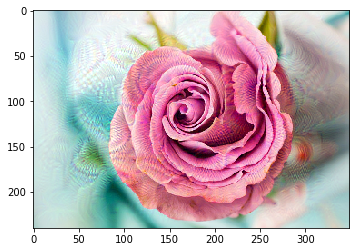

Processing image shape (336, 489)
..Loss value at 0 : 1.3349494
..Loss value at 1 : 1.8031361
..Loss value at 2 : 2.179346
..Loss value at 3 : 2.511866
..Loss value at 4 : 2.8161004
..Loss value at 5 : 3.094743
..Loss value at 6 : 3.3746614
..Loss value at 7 : 3.6306252
..Loss value at 8 : 3.8815742
..Loss value at 9 : 4.1298103
..Loss value at 10 : 4.3654776
..Loss value at 11 : 4.5847006
..Loss value at 12 : 4.8105206
..Loss value at 13 : 5.034805
..Loss value at 14 : 5.2436624
..Loss value at 15 : 5.459154
..Loss value at 16 : 5.652634
..Loss value at 17 : 5.8518248
..Loss value at 18 : 6.041355
..Loss value at 19 : 6.2237253
..Loss value at 20 : 6.398836
..Loss value at 21 : 6.588817
..Loss value at 22 : 6.753911
..Loss value at 23 : 6.933244
..Loss value at 24 : 7.090419
..Loss value at 25 : 7.2718244
..Loss value at 26 : 7.4267006
..Loss value at 27 : 7.5978937
..Loss value at 28 : 7.749419
..Loss value at 29 : 7.9137363
Octave:  2


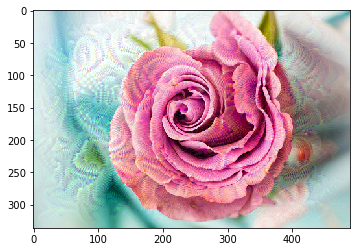

Processing image shape (471, 685)
..Loss value at 0 : 1.5264443
..Loss value at 1 : 2.0769548
..Loss value at 2 : 2.5246537
..Loss value at 3 : 2.9135962
..Loss value at 4 : 3.2777948
..Loss value at 5 : 3.612186
..Loss value at 6 : 3.9296832
..Loss value at 7 : 4.221443
..Loss value at 8 : 4.5060053
..Loss value at 9 : 4.7753854
..Loss value at 10 : 5.0318127
..Loss value at 11 : 5.274452
..Loss value at 12 : 5.516779
..Loss value at 13 : 5.744481
..Loss value at 14 : 5.9673576
..Loss value at 15 : 6.177401
..Loss value at 16 : 6.390091
..Loss value at 17 : 6.5917187
..Loss value at 18 : 6.789194
..Loss value at 19 : 6.9829087
..Loss value at 20 : 7.1744986
..Loss value at 21 : 7.354194
..Loss value at 22 : 7.5450926
..Loss value at 23 : 7.714856
..Loss value at 24 : 7.8973856
..Loss value at 25 : 8.060685
..Loss value at 26 : 8.235265
..Loss value at 27 : 8.388012
..Loss value at 28 : 8.555281
..Loss value at 29 : 8.710454
Octave:  3


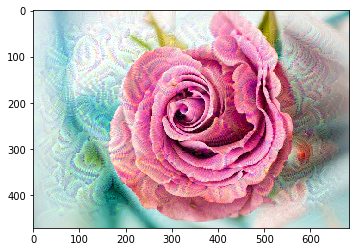

Processing image shape (660, 960)
..Loss value at 0 : 1.6380973
..Loss value at 1 : 2.2183034
..Loss value at 2 : 2.6920512
..Loss value at 3 : 3.087691
..Loss value at 4 : 3.4587383
..Loss value at 5 : 3.8014522
..Loss value at 6 : 4.1231003
..Loss value at 7 : 4.4214115
..Loss value at 8 : 4.7080407
..Loss value at 9 : 4.9832993
..Loss value at 10 : 5.2381163
..Loss value at 11 : 5.498008
..Loss value at 12 : 5.740399
..Loss value at 13 : 5.9757977
..Loss value at 14 : 6.196106
..Loss value at 15 : 6.416106
..Loss value at 16 : 6.621821
..Loss value at 17 : 6.832799
..Loss value at 18 : 7.0330915
..Loss value at 19 : 7.2325063
..Loss value at 20 : 7.4247575
..Loss value at 21 : 7.61478
..Loss value at 22 : 7.80422
..Loss value at 23 : 7.9939322
..Loss value at 24 : 8.176085
..Loss value at 25 : 8.369404
..Loss value at 26 : 8.549721
..Loss value at 27 : 8.752182
..Loss value at 28 : 8.944992
..Loss value at 29 : 9.148323
Final Dream


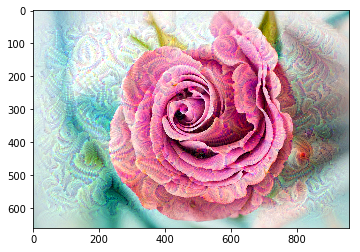

In [31]:
img = preprocess_image(img_path)
produce_deep_dream(img, layer_contributions, param_dict, show_intermediates=True)

It is interesting to observe the CNN to develop a new shape inside the bud of the flower. The CNN adds waves and patterns to the image which may indicate the patterns the CNN is trained to lookout for

## Adding Jitter to the Original Image

Processing image shape (240, 349)
..Loss value at 0 : 0.8304787
..Loss value at 1 : 1.0206028
..Loss value at 2 : 1.2015132
..Loss value at 3 : 1.3746021
..Loss value at 4 : 1.5346179
..Loss value at 5 : 1.7134504
..Loss value at 6 : 1.8642302
..Loss value at 7 : 2.0158525
..Loss value at 8 : 2.168811
..Loss value at 9 : 2.3236248
..Loss value at 10 : 2.471426
..Loss value at 11 : 2.6172698
..Loss value at 12 : 2.7654498
..Loss value at 13 : 2.9109077
..Loss value at 14 : 3.0381026
..Loss value at 15 : 3.191209
..Loss value at 16 : 3.3159819
..Loss value at 17 : 3.4662943
..Loss value at 18 : 3.5914445
..Loss value at 19 : 3.7390392
..Loss value at 20 : 3.8653693
..Loss value at 21 : 4.0000386
..Loss value at 22 : 4.14132
..Loss value at 23 : 4.26942
..Loss value at 24 : 4.408159
..Loss value at 25 : 4.5388293
..Loss value at 26 : 4.675886
..Loss value at 27 : 4.8047476
..Loss value at 28 : 4.947124
..Loss value at 29 : 5.074709
Octave:  1


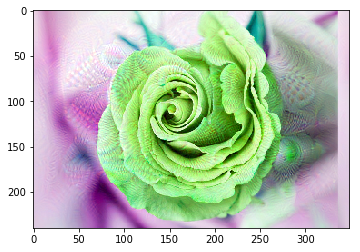

Processing image shape (336, 489)
..Loss value at 0 : 1.3476301
..Loss value at 1 : 1.8354187
..Loss value at 2 : 2.218183
..Loss value at 3 : 2.5495162
..Loss value at 4 : 2.8648386
..Loss value at 5 : 3.1368437
..Loss value at 6 : 3.4185543
..Loss value at 7 : 3.6642067
..Loss value at 8 : 3.9084005
..Loss value at 9 : 4.1409616
..Loss value at 10 : 4.361768
..Loss value at 11 : 4.5811634
..Loss value at 12 : 4.7835946
..Loss value at 13 : 4.9841447
..Loss value at 14 : 5.1812367
..Loss value at 15 : 5.366804
..Loss value at 16 : 5.5626206
..Loss value at 17 : 5.736357
..Loss value at 18 : 5.9283156
..Loss value at 19 : 6.10313
..Loss value at 20 : 6.281622
..Loss value at 21 : 6.4516587
..Loss value at 22 : 6.6212378
..Loss value at 23 : 6.7880282
..Loss value at 24 : 6.9512744
..Loss value at 25 : 7.1210365
..Loss value at 26 : 7.272447
..Loss value at 27 : 7.427737
..Loss value at 28 : 7.582382
..Loss value at 29 : 7.733325
Octave:  2


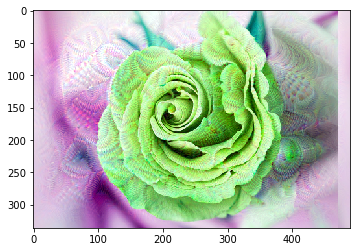

Processing image shape (471, 685)
..Loss value at 0 : 1.5071161
..Loss value at 1 : 2.0654883
..Loss value at 2 : 2.5063562
..Loss value at 3 : 2.8900175
..Loss value at 4 : 3.2471006
..Loss value at 5 : 3.569179
..Loss value at 6 : 3.8687654
..Loss value at 7 : 4.1598606
..Loss value at 8 : 4.429379
..Loss value at 9 : 4.703002
..Loss value at 10 : 4.9504156
..Loss value at 11 : 5.189322
..Loss value at 12 : 5.4304924
..Loss value at 13 : 5.6484785
..Loss value at 14 : 5.8667755
..Loss value at 15 : 6.072053
..Loss value at 16 : 6.2834396
..Loss value at 17 : 6.477078
..Loss value at 18 : 6.6738415
..Loss value at 19 : 6.862925
..Loss value at 20 : 7.052421
..Loss value at 21 : 7.227989
..Loss value at 22 : 7.410104
..Loss value at 23 : 7.5827656
..Loss value at 24 : 7.754654
..Loss value at 25 : 7.923257
..Loss value at 26 : 8.091175
..Loss value at 27 : 8.250551
..Loss value at 28 : 8.407893
..Loss value at 29 : 8.571039
Octave:  3


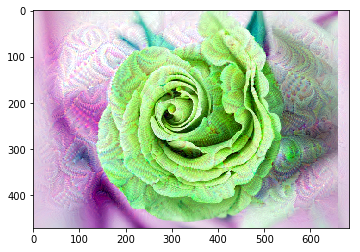

Processing image shape (660, 960)
..Loss value at 0 : 1.6355336
..Loss value at 1 : 2.2356517
..Loss value at 2 : 2.725893
..Loss value at 3 : 3.1292162
..Loss value at 4 : 3.4941363
..Loss value at 5 : 3.829883
..Loss value at 6 : 4.154606
..Loss value at 7 : 4.459823
..Loss value at 8 : 4.753431
..Loss value at 9 : 5.0349903
..Loss value at 10 : 5.3067183
..Loss value at 11 : 5.560951
..Loss value at 12 : 5.807315
..Loss value at 13 : 6.061425
..Loss value at 14 : 6.293647
..Loss value at 15 : 6.5298777
..Loss value at 16 : 6.754039
..Loss value at 17 : 6.975372
..Loss value at 18 : 7.1875467
..Loss value at 19 : 7.393693
..Loss value at 20 : 7.6008177
..Loss value at 21 : 7.795662
..Loss value at 22 : 7.9889965
..Loss value at 23 : 8.189735
..Loss value at 24 : 8.374014
..Loss value at 25 : 8.558729
..Loss value at 26 : 8.738423
..Loss value at 27 : 8.914691
..Loss value at 28 : 9.091132
..Loss value at 29 : 9.260823
Final Dream


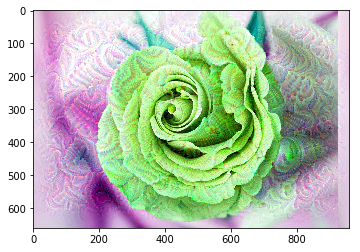

In [32]:
jitter_img = add_jitter(img)
produce_deep_dream(jitter_img, layer_contributions, param_dict, show_intermediates=True)

The jitter function "shifts" the array over some random amount which in turn changes the color output of the image. There does seem to be more pattern creation and the flower's leaves look more like a cabbage than a flower. Most likely due to the color change.

## Exceptional Work: White Noise

We hypothesized that by adding white noise to the original image then passing the CNN over it, the features the CNN extracts should be more evidently clear. The white noise we added comes from a random uniform distribution from 0 to 1. 

Processing image shape (240, 349)
..Loss value at 0 : 0.6748188
..Loss value at 1 : 0.83140576
..Loss value at 2 : 0.9939843
..Loss value at 3 : 1.1556339
..Loss value at 4 : 1.3173468
..Loss value at 5 : 1.4868098
..Loss value at 6 : 1.65307
..Loss value at 7 : 1.8233843
..Loss value at 8 : 1.991235
..Loss value at 9 : 2.1591098
..Loss value at 10 : 2.3209236
..Loss value at 11 : 2.4911757
..Loss value at 12 : 2.6487057
..Loss value at 13 : 2.7982311
..Loss value at 14 : 2.9508872
..Loss value at 15 : 3.0966067
..Loss value at 16 : 3.24295
..Loss value at 17 : 3.3905215
..Loss value at 18 : 3.5293908
..Loss value at 19 : 3.6666615
..Loss value at 20 : 3.8113213
..Loss value at 21 : 3.937686
..Loss value at 22 : 4.081298
..Loss value at 23 : 4.206951
..Loss value at 24 : 4.343585
..Loss value at 25 : 4.472577
..Loss value at 26 : 4.605834
..Loss value at 27 : 4.737996
..Loss value at 28 : 4.8639507
..Loss value at 29 : 4.9895897
Octave:  1


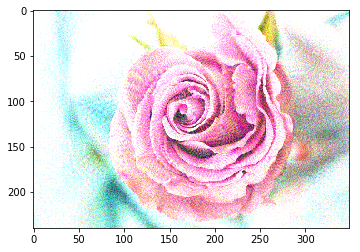

Processing image shape (336, 489)
..Loss value at 0 : 1.04037
..Loss value at 1 : 1.4015574
..Loss value at 2 : 1.7488166
..Loss value at 3 : 2.072296
..Loss value at 4 : 2.3795984
..Loss value at 5 : 2.6657481
..Loss value at 6 : 2.9301257
..Loss value at 7 : 3.1930442
..Loss value at 8 : 3.4394283
..Loss value at 9 : 3.6832795
..Loss value at 10 : 3.9159245
..Loss value at 11 : 4.13523
..Loss value at 12 : 4.3560185
..Loss value at 13 : 4.5591397
..Loss value at 14 : 4.763317
..Loss value at 15 : 4.9652014
..Loss value at 16 : 5.152793
..Loss value at 17 : 5.350415
..Loss value at 18 : 5.5274124
..Loss value at 19 : 5.7033544
..Loss value at 20 : 5.8874273
..Loss value at 21 : 6.057236
..Loss value at 22 : 6.2275643
..Loss value at 23 : 6.3948326
..Loss value at 24 : 6.56573
..Loss value at 25 : 6.7220955
..Loss value at 26 : 6.880041
..Loss value at 27 : 7.0389547
..Loss value at 28 : 7.194951
..Loss value at 29 : 7.342989
Octave:  2


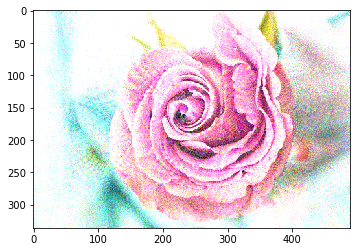

Processing image shape (471, 685)
..Loss value at 0 : 0.8431879
..Loss value at 1 : 1.1174865
..Loss value at 2 : 1.4160751
..Loss value at 3 : 1.7230666
..Loss value at 4 : 2.026041
..Loss value at 5 : 2.323098
..Loss value at 6 : 2.6114528
..Loss value at 7 : 2.891461
..Loss value at 8 : 3.1673777
..Loss value at 9 : 3.4292269
..Loss value at 10 : 3.6914876
..Loss value at 11 : 3.944168
..Loss value at 12 : 4.1905193
..Loss value at 13 : 4.4284353
..Loss value at 14 : 4.658487
..Loss value at 15 : 4.879217
..Loss value at 16 : 5.107309
..Loss value at 17 : 5.3217
..Loss value at 18 : 5.5357885
..Loss value at 19 : 5.742712
..Loss value at 20 : 5.944872
..Loss value at 21 : 6.139244
..Loss value at 22 : 6.3362255
..Loss value at 23 : 6.5239897
..Loss value at 24 : 6.718886
..Loss value at 25 : 6.9044657
..Loss value at 26 : 7.0852118
..Loss value at 27 : 7.26756
..Loss value at 28 : 7.443063
..Loss value at 29 : 7.6234484
Octave:  3


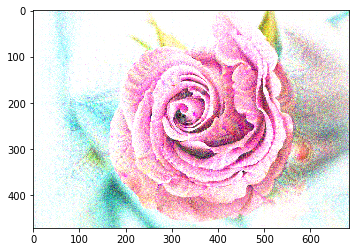

Processing image shape (660, 960)
..Loss value at 0 : 0.939746
..Loss value at 1 : 1.2372863
..Loss value at 2 : 1.5528462
..Loss value at 3 : 1.8675534
..Loss value at 4 : 2.1736944
..Loss value at 5 : 2.4681544
..Loss value at 6 : 2.7540607
..Loss value at 7 : 3.031469
..Loss value at 8 : 3.2959504
..Loss value at 9 : 3.5571067
..Loss value at 10 : 3.8057494
..Loss value at 11 : 4.051098
..Loss value at 12 : 4.2872467
..Loss value at 13 : 4.5165825
..Loss value at 14 : 4.740875
..Loss value at 15 : 4.964592
..Loss value at 16 : 5.179389
..Loss value at 17 : 5.3926477
..Loss value at 18 : 5.5962763
..Loss value at 19 : 5.797847
..Loss value at 20 : 5.9946103
..Loss value at 21 : 6.1873183
..Loss value at 22 : 6.377888
..Loss value at 23 : 6.568223
..Loss value at 24 : 6.747942
..Loss value at 25 : 6.9282856
..Loss value at 26 : 7.1026926
..Loss value at 27 : 7.2780867
..Loss value at 28 : 7.4499216
..Loss value at 29 : 7.61864
Final Dream


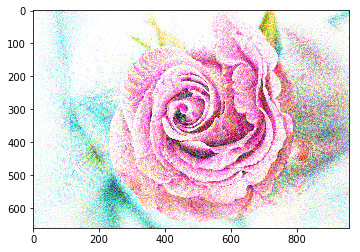

In [36]:
white_noise = np.random.uniform(0,1, size = (img.shape[1],img.shape[2],3))
white_noise = np.expand_dims(white_noise, axis = 0)
noisy_img = white_noise + img
produce_deep_dream(noisy_img, layer_contributions, param_dict, show_intermediates=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


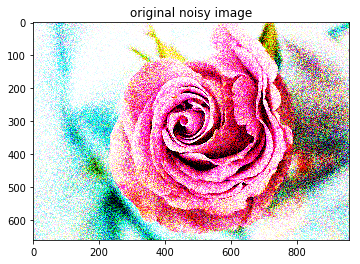

In [37]:
plt.imshow(noisy_img[0])
plt.title('original noisy image')
plt.show()

Theoritically, the white noise added should reveal what the CNN features is trying to extract from the image. 

The image after dream looks to be lighter than the original noisy image. There might be additionally tweaking and other noise to be added to the original image.